In [68]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [23]:
data=np.load("./tmp/all-graphs-IFPQ====-kSys2-kEnvMax2.lambdas.tar.gz-best.npz")
best_ci = data["ci"]
best_graph = data["graph"]

SAMPLES = len(best_ci)

In [24]:
verts, faces, normals, values = measure.marching_cubes_lewiner(best_ci, 0.)

In [105]:
unique_graphs = np.unique(best_graph)
viridis = cm.get_cmap('viridis', len(unique_graphs))

color_lookup = dict(zip(unique_graphs, viridis(np.arange(len(unique_graphs))) ))
vertex_colors = np.array([ color_lookup[best_graph[x,y,z]] for x,y,z in np.round(verts).astype('int') ])
face_colors = np.median(vertex_colors[faces], axis=-2)

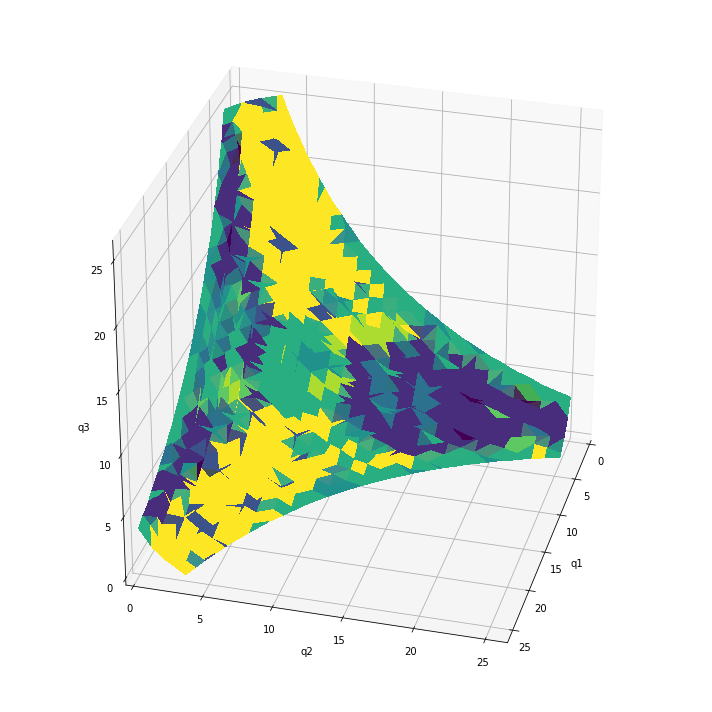

In [106]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=15)

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('none')
mesh.set_linewidth(0)
mesh.set_antialiased(False)
mesh.set_color(face_colors)
mesh.set_cmap(viridis)

ax.add_collection3d(mesh)

ax.set_xlabel("q1")
ax.set_ylabel("q2")
ax.set_zlabel("q3")

ax.set_xlim(0, SAMPLES)
ax.set_ylim(0, SAMPLES) 
ax.set_zlim(0, SAMPLES)

plt.tight_layout()
plt.show()

In [104]:
# export for importing to blender
np.savez_compressed("./blender-data.npz", 
    verts=verts,
    faces=faces,
    normals=normals,
    values=values,
    vertex_colors=vertex_colors
)